In [1]:
# IMPORTS

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import ast

In [2]:
# IMPORT DATA

directory = '.\Data'
all_files = os.listdir(directory)
csv_files = [f for f in all_files if f.startswith('CAMP') and f.endswith('csv')]

data_list = []

for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, encoding='latin-1')
    data_list.append(df)

data_concat = pd.concat(data_list, ignore_index=True)

# DROP UNUSED COLUMNS
data_concat = data_concat.drop(columns=['OBJECTID', 'NUMERO_ORDINE', 'TECNICO', 'ID', 'TIPOLOGIA'])

# ADJUST DATE FORMAT
data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat.DATA_RILEVAMENTO, format='mixed')

# ADJUST SPECIES NAMES
# Remove non-species
data_concat = data_concat[~data_concat['SPECIE'].isin(['06', '****', 'nan']) & ~data_concat['SPECIE'].isna()]

# Group same species under same name (replacement dictionaries are in 'Species.txt')
with open('Species.txt', 'r') as file:
    file_content = file.read()

replacement_dict_list = ast.literal_eval(file_content)
for replacement_dict in replacement_dict_list:
    data_concat['SPECIE'] = data_concat['SPECIE'].replace(replacement_dict)

# ADJUST CASE IN OTHER COLUMNS
column_list = ['CULTIVAR', 'RISULTATO', 'COMUNE', 'SINTOMO']

for column in column_list:
    data_concat[column] = data_concat[column].str.capitalize()

# SORT BY DATE
data_concat = data_concat.sort_values(by='DATA_RILEVAMENTO')

# REMOVE ROWS WITH NO COORDINATE DATA
data_concat = data_concat.dropna(subset=['LATITUDINE', 'LONGITUDINE'])

# REMOVE WRONG DATA
lat_min = 39.0
lon_max = 18.9
mask = (data_concat['LATITUDINE'] < lat_min) & (data_concat['LONGITUDINE'] > lon_max)
data_concat = data_concat[~mask]

# EXPORT CLEANED DATAFRAME
data_concat.to_csv('.\Data\Dati_monitoraggio_2013-2023.csv', index=False)


In [3]:
# IMPORT CLEANED DATAFRAME
data_concat = pd.read_csv('.\Data\Dati_monitoraggio_2013-2023.csv', low_memory=False)
data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat['DATA_RILEVAMENTO'])

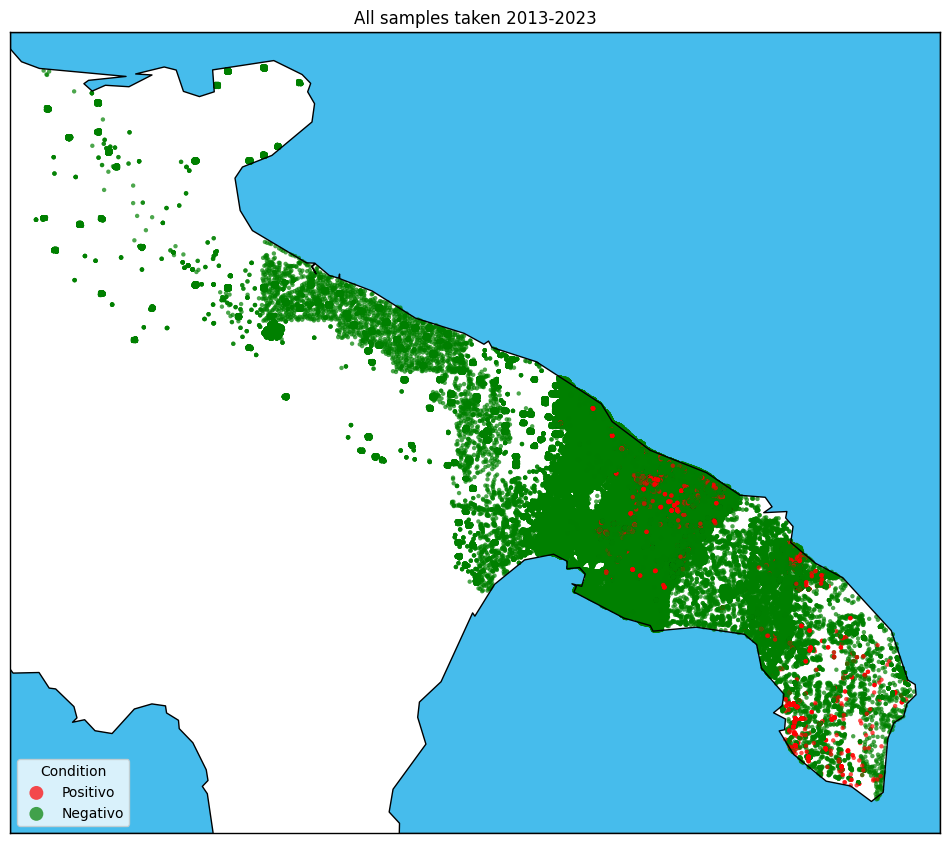

In [4]:
# Coordinate data of samples
lat = data_concat['LATITUDINE'].values
lon = data_concat['LONGITUDINE'].values

# Map margins
margin = 0.1 # buffer to add to the range
lat_min = np.min(lat) - margin
lat_max = np.max(lat) + margin
lon_min = np.min(lon) - margin
lon_max = np.max(lon) + margin

color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_concat['color'] = data_concat['RISULTATO'].map(color_map)

fig, ax = plt.subplots(figsize=(12,12))
m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2, lon_0=(lon_max-lon_min)/2,
            projection='merc', resolution = 'i', area_thresh=10000., ax = ax)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white',lake_color='#46bcec')

lons, lats = m(lon, lat)
sc = m.scatter(lons, lats, c=data_concat['color'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# Legend
for condition in color_map:
    ax.scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
ax.legend(title='Condition', loc='lower left')

year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
year_min = np.min(year_list)
year_max = np.max(year_list)
plt.title(f'All samples taken {year_min}-{year_max}')
plt.show()

In [59]:
# # Plot only positive or negatives
# positives = data_concat[data_concat['RISULTATO'] == 'Positivo']
# negatives = data_concat[data_concat['RISULTATO'] == 'Negativo']

# lat_pos = positives['LATITUDINE'].values
# lon_pos = positives['LONGITUDINE'].values
# lat_neg = negatives['LATITUDINE'].values
# lon_neg = negatives['LONGITUDINE'].values

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# # create map using BASEMAP
# m1 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[0]
#             )

# m1.drawcoastlines()
# m1.drawcountries()
# m1.drawstates()
# m1.drawmapboundary(fill_color='#46bcec')
# m1.fillcontinents(color='white',lake_color='#46bcec')

# lons_pos, lats_pos = m1(lon_pos, lat_pos)
# m1.scatter(lons_pos, lats_pos, c='red', marker='o', s=10, edgecolor='none', alpha=0.7)

# m2 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[1]
#             )

# m2.drawcoastlines()
# m2.drawcountries()
# m2.drawstates()
# m2.drawmapboundary(fill_color='#46bcec')
# m2.fillcontinents(color='white',lake_color='#46bcec')

# lons_neg, lats_neg = m2(lon_neg, lat_neg)
# m2.scatter(lons_neg, lats_neg, c='green', marker='o', s=10, edgecolor='none', alpha=0.7)

# # Show the plot
# ax[0].set_title('Positive tests')
# ax[1].set_title('Negative tests')
# plt.show()


In [60]:
# n_positives = len(positives)
# n_negatives = len(negatives)
# print(f'Percentage of positive tests: {np.round(n_positives / (n_positives + n_negatives) * 100, decimals=2)}%')

In [61]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# from matplotlib.animation import FuncAnimation, PillowWriter
# import numpy as np

# data_new = data_concat.sort_values(by='DATA_RILEVAMENTO')
# # size = 10000
# # data_new = data_new[:size]
# # print(len(data_new))
# # display(data_new)

# # Define colors based on the test result
# color_map = {'Positivo': 'red', 'Negativo': 'green'}
# data_new['color'] = data_new['RISULTATO'].map(color_map)

# # Create figure and Basemap
# fig, ax = plt.subplots(figsize=(10, 8))
# m = Basemap(projection='merc', 
#             llcrnrlat=lat_min, 
#             urcrnrlat=lat_max, 
#             llcrnrlon=lon_min, 
#             urcrnrlon=lon_max, 
#             resolution='i', 
#             ax=ax)

# # Draw map details
# m.drawcoastlines()
# m.drawcountries()
# m.drawstates()
# m.drawmapboundary(fill_color='aqua')
# m.fillcontinents(color='lightgreen', lake_color='aqua')

# # Function to update scatter plot for each frame
# def update(frame):
#     ax.clear()
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='aqua')
#     m.fillcontinents(color='lightgreen', lake_color='aqua')
    
#     # Get data up to the current frame
#     current_date = unique_dates[frame]
#     current_data = data_new[data_new['DATA_RILEVAMENTO'] <= current_date]
    
#     # Plot scatter points
#     x, y = m(current_data['LONGITUDINE'].values, current_data['LATITUDINE'].values)
#     sc = m.scatter(x, y, c=current_data['color'].values, marker='o', s=10, edgecolor='none', alpha=0.7)
    
#     # Set the title
#     ax.set_title(f'Test Results as of {current_date.date()}')

# # Extract unique dates for frames
# unique_dates = data_new['DATA_RILEVAMENTO'].unique()

# # Create animation
# ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

# # Save animation as a video file (optional)
# ani.save('epidemic_evolution.gif',
#           writer=PillowWriter(fps=10))

# # Display animation
# plt.show()


In [ ]:
# # PLOT SAMPLING YEAR BY YEAR

# year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
# # year_list = [2013, 2014]

# color_map = {'Positivo': 'red', 'Negativo': 'green'}

# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# for i, year in enumerate(year_list):
#     yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year].copy()
    
#     lat = yearly_data['LATITUDINE'].values
#     lon = yearly_data['LONGITUDINE'].values
    
#     row = i // ncols
#     col = i % ncols
    
#     yearly_data['color'] = yearly_data['RISULTATO'].map(color_map)

#     m = Basemap(llcrnrlon=lon_min,
#                 llcrnrlat=lat_min,
#                 urcrnrlon=lon_max,
#                 urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2,
#                 lon_0=(lon_max-lon_min)/2,
#                 projection='merc',
#                 resolution = 'i',
#                 area_thresh=10000.,
#                 ax=ax[row,col]
#                 )
    
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c=yearly_data['color'].values, marker='o', s=0.2, edgecolor='none', alpha=0.7)

#     for condition in color_map:
#         ax[row,col].scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
#     ax[row,col].legend(title='Condition', loc='lower left')

#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# fig.suptitle('Yearly samples', fontsize=16)
# plt.show()

In [ ]:
# # PLOT POSITIVE SAMPLES YEAR BY YEAR

# year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
# # year_list = [2013, 2014]

# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# positives = data_concat[data_concat['RISULTATO'] == 'Positivo']

# for i, year in enumerate(year_list):
#     yearly_data = positives[positives['DATA_RILEVAMENTO'].dt.year == year].copy()
    
#     lat = yearly_data['LATITUDINE'].values
#     lon = yearly_data['LONGITUDINE'].values
    
#     row = i // ncols
#     col = i % ncols

#     m = Basemap(llcrnrlon=lon_min,
#                 llcrnrlat=lat_min,
#                 urcrnrlon=lon_max,
#                 urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2,
#                 lon_0=(lon_max-lon_min)/2,
#                 projection='merc',
#                 resolution = 'i',
#                 area_thresh=10000.,
#                 ax=ax[row,col]
#                 )
    
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c='r', marker='o', s=0.5, edgecolor='none', alpha=0.7)

#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# fig.suptitle('Yearly positive samples', fontsize=16)
# plt.show()

In [46]:
# CREATE WEEK COLUMN
data_concat['SETTIMANA'] = data_concat['DATA_RILEVAMENTO'].dt.isocalendar().week

,DATA_RILEVAMENTO,SPECIE,LATITUDINE,LONGITUDINE,CULTIVAR,RISULTATO,COMUNE,SINTOMO,SETTIMANA
3296,2013-11-13,Olivo (Olea europaea),40.053056,18.363611,****,Negativo,Poggiardo,NaN,46
3304,2013-11-13,Olivo (Olea europaea),40.326389,18.372500,****,Negativo,Melendugno,NaN,46
3305,2013-11-13,Vite (di ogni specie),40.213611,18.447778,****,Negativo,Otranto,NaN,46
3306,2013-11-13,Vite (di ogni specie),40.191944,18.448889,****,Negativo,Otranto,NaN,46
3307,2013-11-13,Vite (di ogni specie),40.179444,18.461111,****,Negativo,Otranto,NaN,46
...,...,...,...,...,...,...,...,...,...
996201,2023-12-06,Olivo (Olea europaea),40.735740,17.285929,Altro,Negativo,Martina franca,Assente,49
996202,2023-12-06,Olivo (Olea europaea),40.736212,17.286001,Altro,Negativo,Martina franca,Assente,49
996203,2023-12-06,Olivo (Olea europaea),40.750235,17.299963,Oliastro,Negativo,Martina franca,Assente,49
996205,2023-12-06,Olivo (Olea europaea),40.785093,16.737358,Altro,Negativo,Santeramo in colle,Assente,49


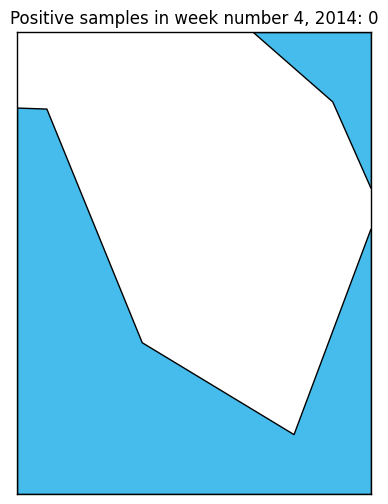

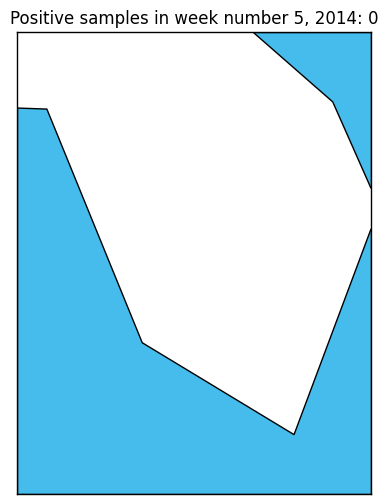

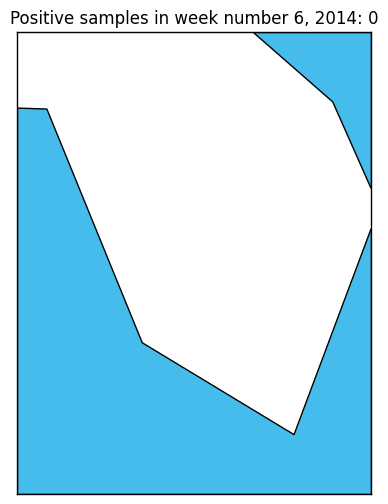

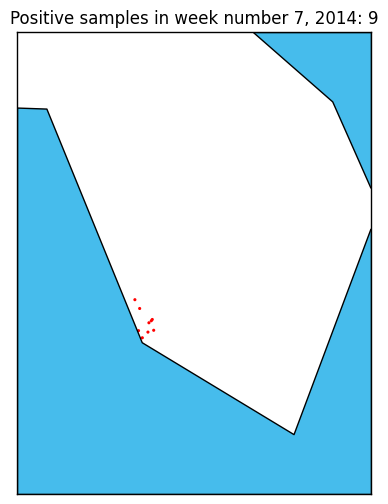

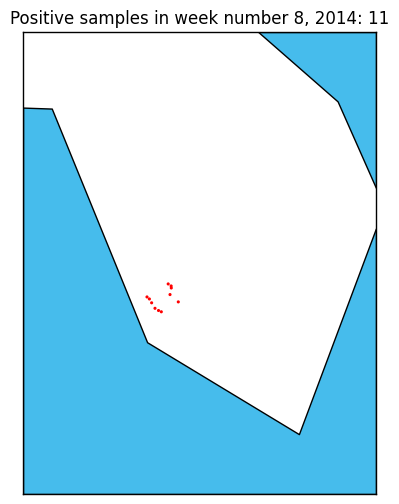

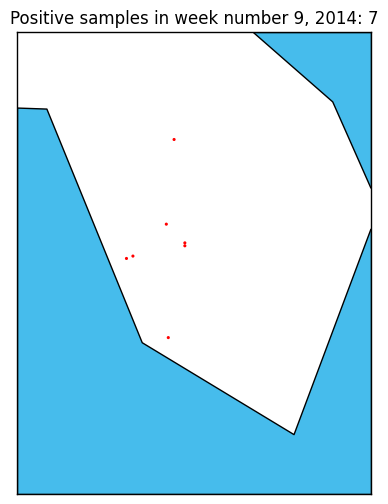

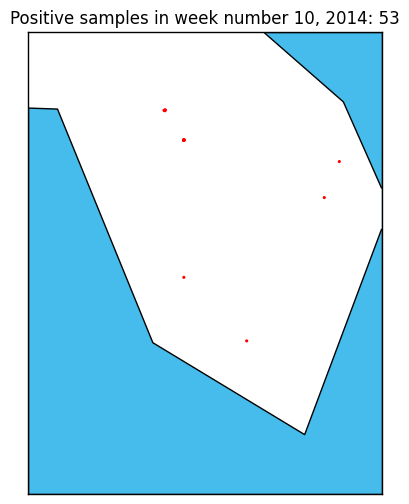

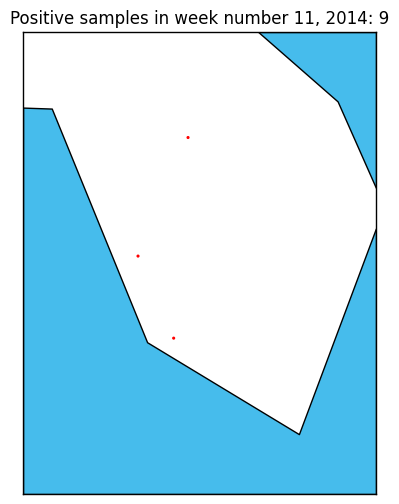

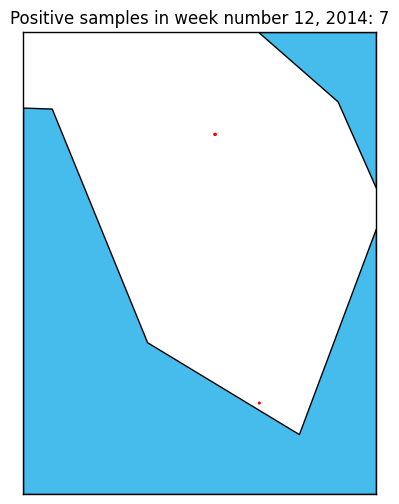

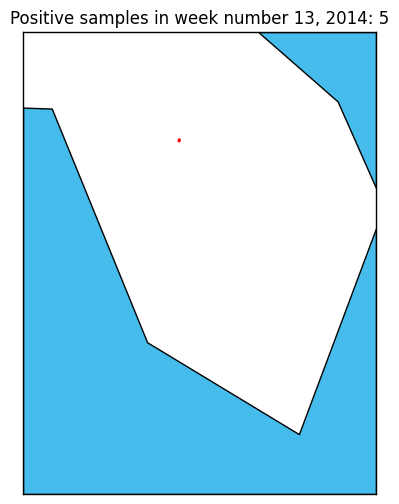

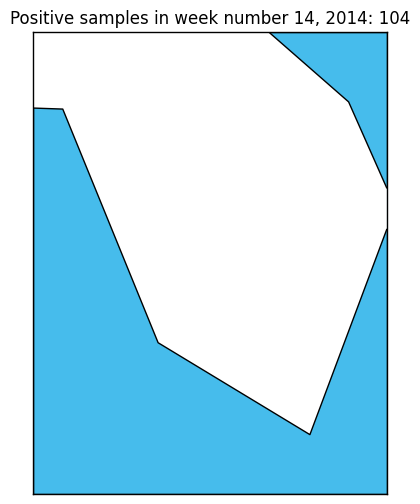

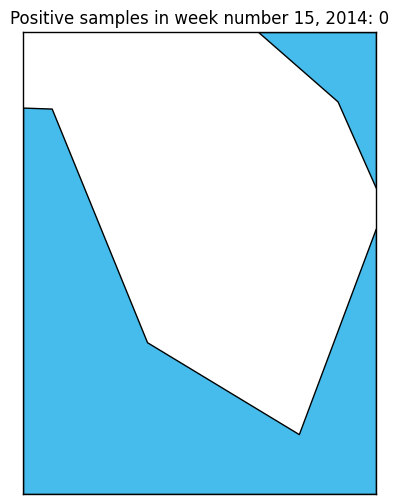

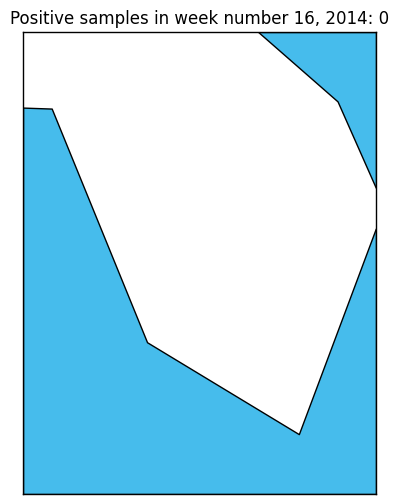

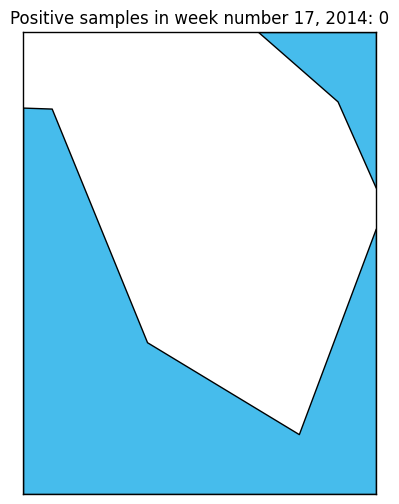

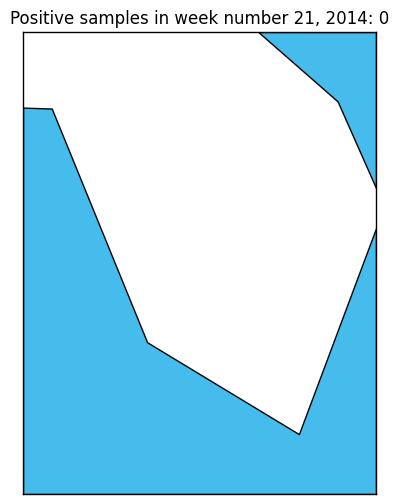

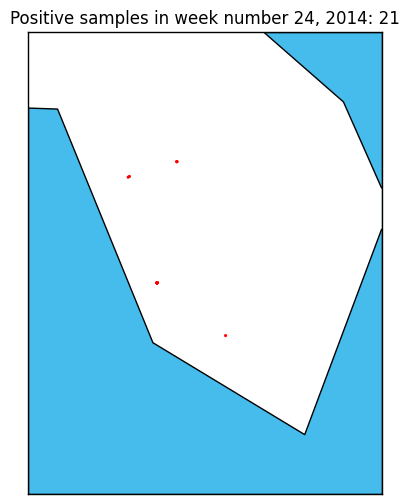

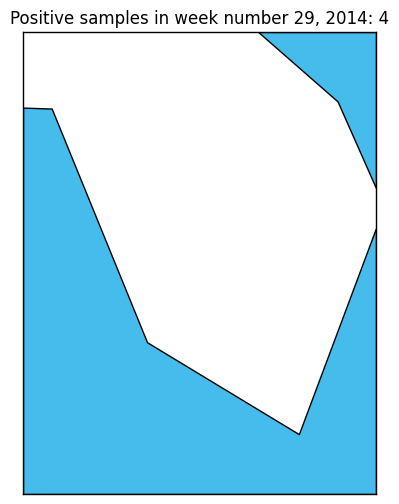

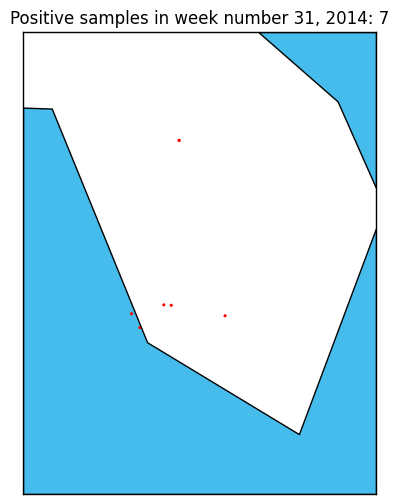

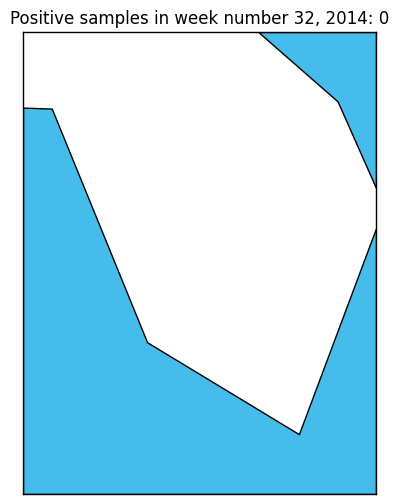

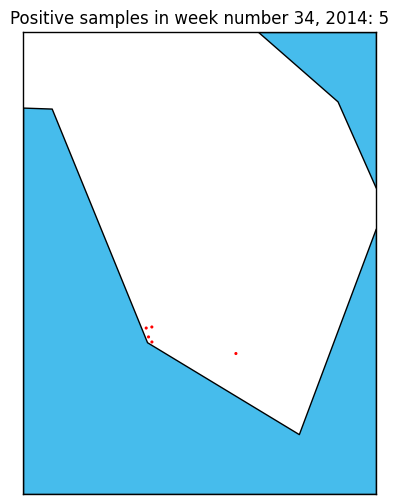

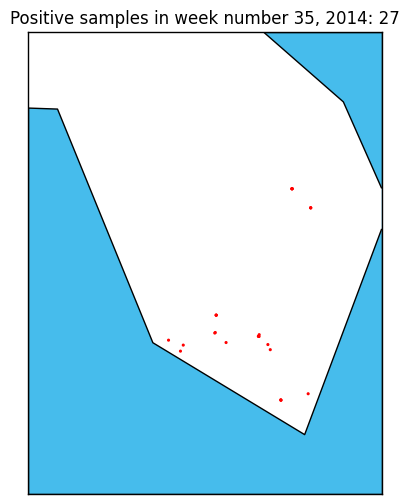

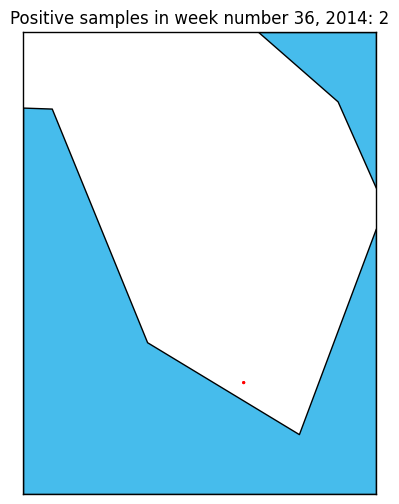

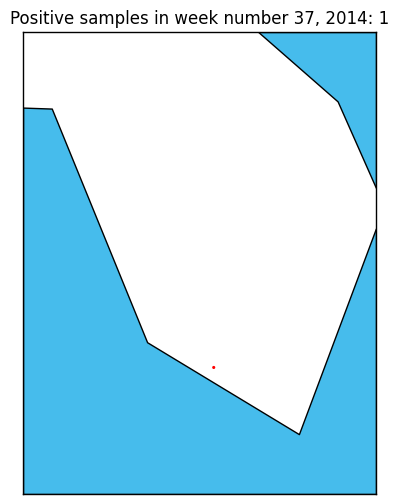

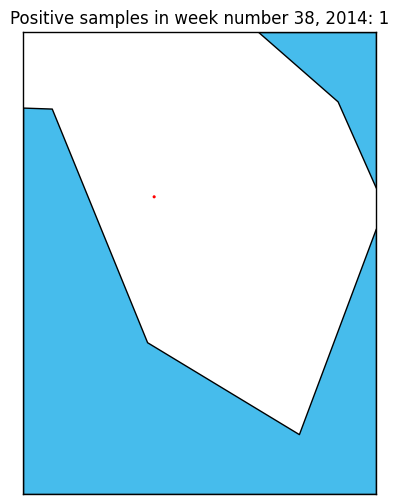

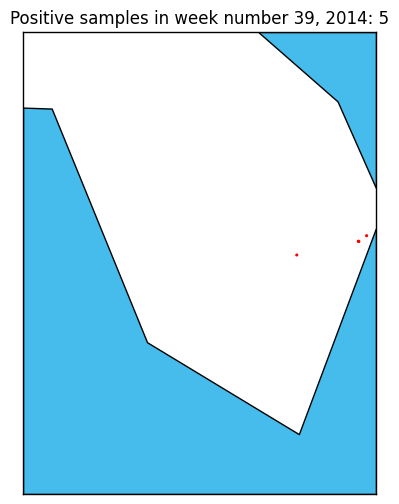

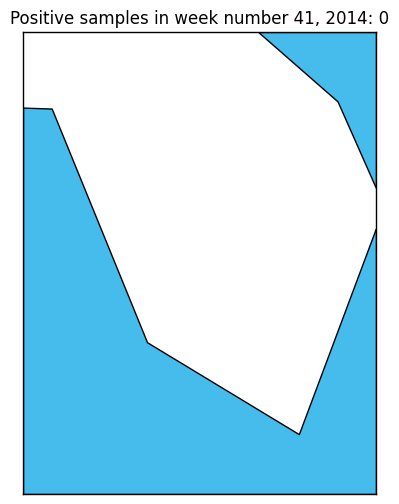

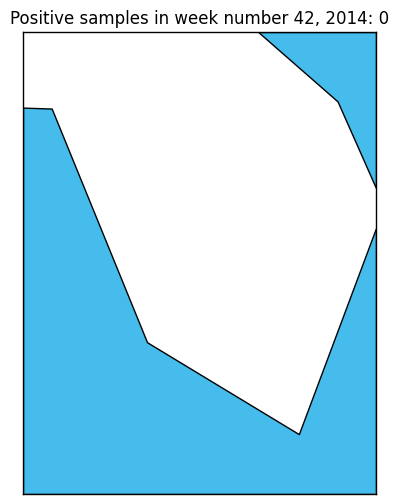

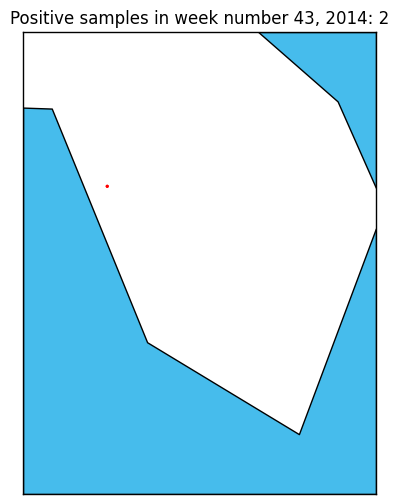

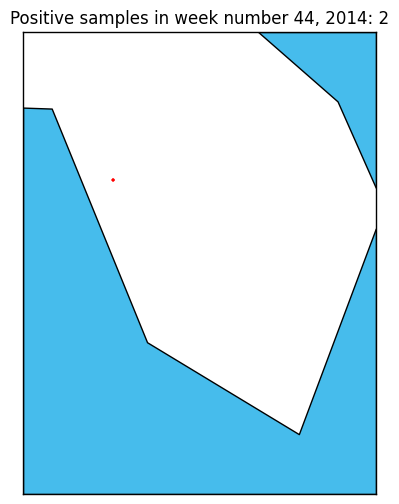

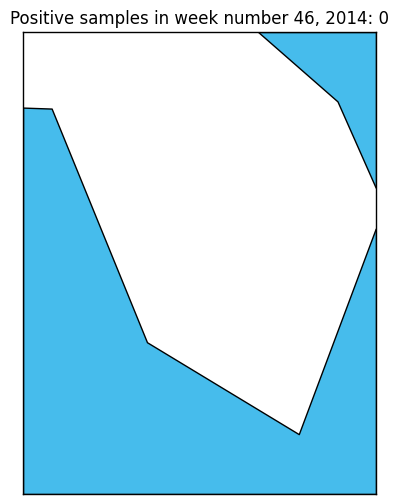

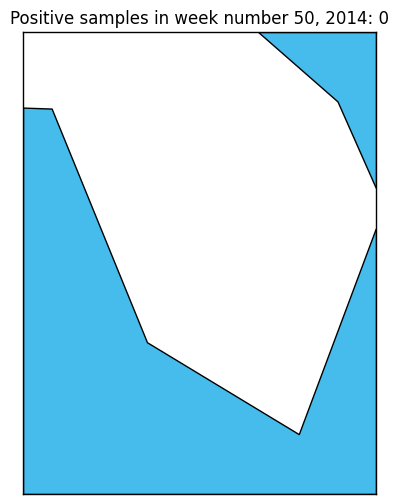

In [53]:
# PLOT POSITIVE SAMPLES 2013 WEEK BY WEEK

year = 2014
year_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
# date_list = year_data['DATA_RILEVAMENTO'].unique()
week_list = year_data['SETTIMANA'].unique()
positives = year_data[year_data['RISULTATO'] == 'Positivo']

lat_min = 39.7
lat_max = 40.4
lon_min = 17.8
lon_max = 18.5

# for i, date in enumerate(date_list):
for i, week in enumerate(week_list):
    # daily_data = positives[positives['DATA_RILEVAMENTO'] == date].copy()
    weekly_data = positives[positives['SETTIMANA'] == week].copy()

    # print(f'Positive tests on {date}: {len(daily_data)}')
    # print(f'Positive tests on week number {week}, {year}: {len(weekly_data)}')
    
    # lat = daily_data['LATITUDINE'].values
    # lon = daily_data['LONGITUDINE'].values
    lat = weekly_data['LATITUDINE'].values
    lon = weekly_data['LONGITUDINE'].values
    
    fig, ax = plt.subplots(figsize=(6,6))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max-lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'l',
                area_thresh=10000.,
                ax=ax
                )

    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='white',lake_color='#46bcec')

    lons, lats = m(lon, lat)
    sc = m.scatter(lons, lats, c='r', marker='o', s=5, edgecolor='none', alpha=1)

    # ax.set_title(f'Samples {date}')
    ax.set_title(f'Positive samples in week number {week}, {year}: {len(weekly_data)}')
    plt.show()

In [ ]:
# YEAR